# Example 33: USGS Gauge Catalog Generation

This notebook demonstrates how to generate and use a standardized USGS gauge data catalog for your HEC-RAS project.

## Purpose

The gauge catalog generation function creates a standardized "USGS Gauge Data" folder (similar to the precipitation module's storm catalog) that:
- Discovers all active USGS gauges within project extent
- Downloads historical data for each gauge
- Creates master catalog for easy gauge discovery
- Provides standard location for engineering review and downstream functions

## Key Functions

- `generate_gauge_catalog()`: Create complete gauge catalog with metadata and data
- `load_gauge_catalog()`: Load gauge catalog from standard location
- `load_gauge_data()`: Load historical data for specific gauge
- `get_gauge_folder()`: Get path to gauge folder
- `update_gauge_catalog()`: Refresh catalog with latest data

## Example Project

We'll use the **Bald Eagle Creek** example project which has 2 active USGS gauges:
- USGS-01547200: Upstream gauge (265 sq mi drainage)
- USGS-01548005: Downstream gauge (562 sq mi drainage)

## Dependencies

Requires: `pip install dataretrieval geopandas tqdm`

## 1. Setup and Initialization

In [ ]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import init_ras_project, ras, RasExamples
from ras_commander.usgs import (
    generate_gauge_catalog,
    load_gauge_catalog,
    load_gauge_data,
    get_gauge_folder,
    update_gauge_catalog
)

# Additional imports
import pandas as pd
import json

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

## 2. Extract Example Project

In [2]:
# Extract Bald Eagle Creek project
project_path = RasExamples.extract_project("Balde Eagle Creek", output_path="example_projects_420_usgs_gauge_catalog")

print(f"Project extracted to: {project_path}")

# Initialize project
init_ras_project(project_path, "6.6")

print(f"\nProject: {ras.project_name}")
print(f"Path: {ras.project_folder}")
print(f"\nProject initialized successfully")

2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek'
2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - Folder 'Balde Eagle Creek' already exists. Deleting existing folder...
2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - Existing folder 'Balde Eagle Creek' has been deleted.
2025-12-14 21:14:57 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to c:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek
2025-12-14 21:14:57 - ras_commander.RasMap - INFO - Successfully

Project extracted to: c:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek

Project: BaldEagle
Path: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek

Project initialized successfully


## 3. Generate Gauge Catalog

This will:
1. Find all USGS gauges within 50% buffer of project extent
2. Download 10 years of historical data (flow and stage)
3. Create standardized folder structure
4. Generate master catalog and documentation

In [3]:
# Note: Bald Eagle Creek project doesn't have embedded CRS, so we specify it manually
# The project uses PA State Plane North (US feet) - EPSG:2271
summary = generate_gauge_catalog(
    buffer_percent=50.0,         # Search within 50% buffer of project extent
    include_historical=True,     # Download historical data
    historical_years=10,         # Last 10 years of data
    parameters=['flow', 'stage'], # Retrieve flow and stage data
    project_crs="EPSG:2271"      # PA State Plane North (US feet) - required for Bald Eagle
)

# Display summary
print("\n" + "="*60)
print("GAUGE CATALOG GENERATION SUMMARY")
print("="*60)
print(f"Gauges found: {summary['gauge_count']}")
print(f"Successfully processed: {summary['gauges_processed']}")
print(f"Failed: {summary['gauges_failed']}")
print(f"Output folder: {summary['output_folder']}")
print(f"Data size: {summary['data_size_mb']:.2f} MB")
print(f"Processing time: {summary['processing_time_sec']:.1f} seconds")
print("="*60)

2025-12-14 21:14:57 - ras_commander.usgs.catalog - INFO - Generating USGS gauge catalog for project: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek
2025-12-14 21:14:57 - ras_commander.usgs.catalog - INFO - Output folder: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\USGS Gauge Data
2025-12-14 21:14:57 - ras_commander.usgs.catalog - INFO - Buffer: 50.0%, Historical years: 10
2025-12-14 21:14:57 - ras_commander.usgs.catalog - INFO - Step 1/7: Finding gauges in project extent...
2025-12-14 21:14:57 - ras_commander.usgs.spatial - INFO - Retrieving project bounds from: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-14 21:14:57 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-14 21:14:57 - ras_commander.hdf.H


GAUGE CATALOG GENERATION SUMMARY
Gauges found: 47
Successfully processed: 47
Failed: 0
Output folder: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\USGS Gauge Data
Data size: 108.44 MB
Processing time: 214.7 seconds


## 4. Explore Catalog Structure

The catalog creates a standardized folder structure:

```
project_folder/
├── USGS Gauge Data/
│   ├── gauge_catalog.csv          # Master catalog
│   ├── gauge_locations.geojson    # Spatial data
│   ├── README.md                  # Documentation
│   ├── USGS-01547200/             # Individual gauge folders
│   │   ├── metadata.json
│   │   ├── historical_flow.csv
│   │   ├── historical_stage.csv
│   │   └── data_availability.json
│   └── USGS-01548005/
│       └── ...
```

In [4]:
# List files in catalog folder
catalog_folder = Path(ras.project_path) / "USGS Gauge Data"

print("Catalog folder contents:")
print("\nTop-level files:")
for file in sorted(catalog_folder.glob('*')):
    if file.is_file():
        size_kb = file.stat().st_size / 1024
        print(f"  {file.name:30s} ({size_kb:8.1f} KB)")

print("\nGauge folders:")
for folder in sorted(catalog_folder.glob('USGS-*')):
    if folder.is_dir():
        file_count = len(list(folder.glob('*')))
        print(f"  {folder.name:30s} ({file_count} files)")

Catalog folder contents:

Top-level files:
  gauge_catalog.csv              (     5.5 KB)
  gauge_locations.geojson        (    17.9 KB)
  README.md                      (    10.9 KB)

Gauge folders:
  USGS-01545680                  (2 files)
  USGS-01545700                  (2 files)
  USGS-01545800                  (2 files)
  USGS-01546000                  (2 files)
  USGS-01546100                  (2 files)
  USGS-01547000                  (2 files)
  USGS-01547100                  (4 files)
  USGS-01547200                  (4 files)
  USGS-01547280                  (2 files)
  USGS-01547300                  (2 files)
  USGS-01547400                  (2 files)
  USGS-01547450                  (2 files)
  USGS-01547500                  (4 files)
  USGS-01547600                  (2 files)
  USGS-01547700                  (4 files)
  USGS-01547900                  (2 files)
  USGS-01547950                  (4 files)
  USGS-01547980                  (2 files)
  USGS-01547990           

## 5. Load and Explore Master Catalog

In [5]:
# Load catalog using helper function
catalog = load_gauge_catalog()

print(f"Loaded catalog with {len(catalog)} gauges\n")

# Display key information
print("Gauge Catalog:")
print("-" * 120)
display_cols = ['site_id', 'station_name', 'drainage_area_sqmi', 'upstream_downstream', 
                'distance_to_project_km', 'parameters_available']
print(catalog[display_cols].to_string(index=False))
print("-" * 120)

2025-12-14 21:18:32 - ras_commander.usgs.catalog - INFO - Loaded gauge catalog: 47 gauges from C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\USGS Gauge Data\gauge_catalog.csv


Loaded catalog with 47 gauges

Gauge Catalog:
------------------------------------------------------------------------------------------------------------------------
        site_id                                       station_name  drainage_area_sqmi upstream_downstream  distance_to_project_km  parameters_available
       01545680            Tangascootack Creek near Lock Haven, PA               36.50             unknown                     0.0                   NaN
       01545700                     Queens Run near Lock Haven, PA               18.00             unknown                     0.0                   NaN
       01545800             WB Susquehanna River at Lock Haven, PA             3345.00             unknown                     0.0                   NaN
       01546000            North Bald Eagle Creek at Milesburg, PA              119.00             unknown                     0.0                   NaN
       01546100  Bald Eagle Creek ab Spring Creek at Milesburg, PA  

## 5.1 Visualize Gauge Locations on HEC-RAS Geometry

This section displays all discovered USGS gauges overlaid on the HEC-RAS model geometry,
showing both 1D (river centerlines, cross sections) and 2D (mesh areas) elements.

2025-12-14 21:18:32 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-14 21:18:32 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-14 21:18:32 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-14 21:18:32 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-14 21:18:32 - ras_commander.hdf.HdfXsec - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-14 21:18:32 - ras

Loaded 47 gauge locations
Geometry HDF: C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\BaldEagle.g01.hdf
No 2D mesh areas in this project (1D-only model)
Loaded 1 river centerlines
Loaded 178 cross sections

Reprojecting gauges from EPSG:4326 to EPSG:2271


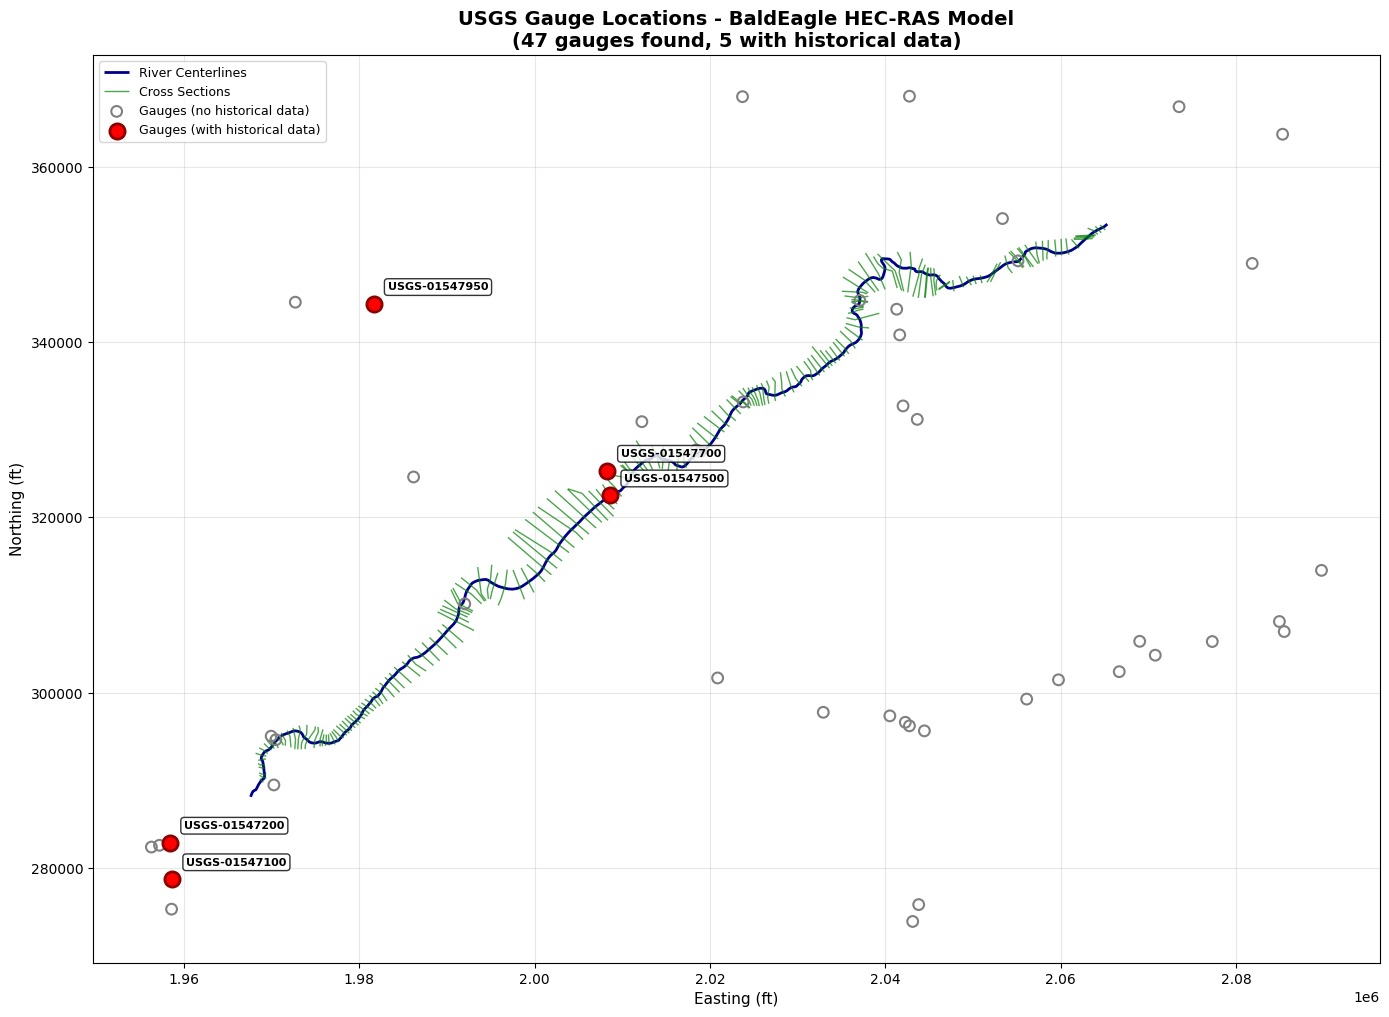


Legend:
  - Blue shaded areas: 2D mesh flow areas
  - Dark blue lines: River centerlines (1D)
  - Green lines: Cross sections (1D)
  - Red circles: USGS gauges with historical data (5)
  - Gray circles: USGS gauges without historical data (42)


In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
from ras_commander.hdf import HdfMesh, HdfXsec

# Load gauge locations from GeoJSON
gauge_locations_file = catalog_folder / "gauge_locations.geojson"
gauges_gdf = gpd.read_file(gauge_locations_file)

print(f"Loaded {len(gauges_gdf)} gauge locations")

# Get geometry HDF path
geom_hdf_path = Path(ras.project_folder) / f"{ras.project_name}.g01.hdf"
print(f"Geometry HDF: {geom_hdf_path}")

# Define project CRS (matches catalog generation)
project_crs = "EPSG:2271"  # PA State Plane North (US feet)

# Load 2D mesh areas (perimeters)
try:
    mesh_areas = HdfMesh.get_mesh_areas(geom_hdf_path)
    has_2d = len(mesh_areas) > 0 if mesh_areas is not None else False
    if has_2d:
        print(f"Loaded {len(mesh_areas)} 2D mesh areas")
        if mesh_areas.crs is None:
            mesh_areas = mesh_areas.set_crs(project_crs)
    else:
        print("No 2D mesh areas in this project (1D-only model)")
except Exception as e:
    mesh_areas = None
    has_2d = False
    print(f"No 2D mesh areas: {e}")

# Load 1D river centerlines
try:
    centerlines = HdfXsec.get_river_centerlines(geom_hdf_path)
    has_centerlines = len(centerlines) > 0 if centerlines is not None else False
    if has_centerlines:
        print(f"Loaded {len(centerlines)} river centerlines")
        if centerlines.crs is None:
            centerlines = centerlines.set_crs(project_crs)
except Exception as e:
    centerlines = None
    has_centerlines = False
    print(f"No river centerlines: {e}")

# Load 1D cross sections
try:
    cross_sections = HdfXsec.get_cross_sections(geom_hdf_path)
    has_xs = len(cross_sections) > 0 if cross_sections is not None else False
    if has_xs:
        print(f"Loaded {len(cross_sections)} cross sections")
        if cross_sections.crs is None:
            cross_sections = cross_sections.set_crs(project_crs)
except Exception as e:
    cross_sections = None
    has_xs = False
    print(f"No cross sections: {e}")

# Reproject gauges to project CRS
if gauges_gdf.crs != project_crs:
    print(f"\nReprojecting gauges from {gauges_gdf.crs} to {project_crs}")
    gauges_gdf = gauges_gdf.to_crs(project_crs)

# Create figure
fig, ax = plt.subplots(figsize=(14, 12))

# Plot 2D mesh areas (if available)
if has_2d:
    mesh_areas.plot(ax=ax, facecolor='lightblue', edgecolor='blue',
                    alpha=0.3, linewidth=1.5, label='2D Mesh Areas')

# Plot 1D river centerlines (if available)
if has_centerlines:
    centerlines.plot(ax=ax, color='darkblue', linewidth=2, label='River Centerlines')

# Plot 1D cross sections (if available)
if has_xs:
    cross_sections.plot(ax=ax, color='green', linewidth=1, alpha=0.7, label='Cross Sections')

# Plot gauge locations - highlight gauges with data
gauges_with_data = ['01547100', '01547200', '01547500', '01547700', '01547950']
gauges_gdf['has_data'] = gauges_gdf['site_id'].astype(str).isin(gauges_with_data)

# Plot gauges without data (smaller, hollow)
no_data = gauges_gdf[~gauges_gdf['has_data']]
if len(no_data) > 0:
    no_data.plot(ax=ax, color='none', edgecolor='gray', markersize=60,
                 marker='o', linewidth=1.5, label='Gauges (no historical data)', zorder=5)

# Plot gauges with data (larger, filled)
with_data = gauges_gdf[gauges_gdf['has_data']]
if len(with_data) > 0:
    with_data.plot(ax=ax, color='red', edgecolor='darkred', markersize=120,
                   marker='o', linewidth=2, label='Gauges (with historical data)', zorder=6)

# Add gauge labels for gauges with data
for idx, row in with_data.iterrows():
    ax.annotate(f"USGS-{row['site_id']}",
                xy=(row.geometry.x, row.geometry.y),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                zorder=7)

# Formatting
ax.set_title(f"USGS Gauge Locations - {ras.project_name} HEC-RAS Model\n"
             f"({len(gauges_gdf)} gauges found, {len(with_data)} with historical data)",
             fontsize=14, fontweight='bold')
ax.set_xlabel('Easting (ft)', fontsize=11)
ax.set_ylabel('Northing (ft)', fontsize=11)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\nLegend:")
print(f"  - Blue shaded areas: 2D mesh flow areas")
print(f"  - Dark blue lines: River centerlines (1D)")
print(f"  - Green lines: Cross sections (1D)")
print(f"  - Red circles: USGS gauges with historical data ({len(with_data)})")
print(f"  - Gray circles: USGS gauges without historical data ({len(no_data)})")

## 6. Load Gauge Metadata

In [7]:
# Find a gauge with metadata - use one of the main Bald Eagle Creek gauges
# USGS-01547200 is mentioned in the introduction as a key gauge with data
site_id = '01547200'  # Bald Eagle Creek bl Spring Creek at Milesburg, PA

gauge_folder = get_gauge_folder(site_id)
metadata_file = gauge_folder / "metadata.json"

with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print(f"Metadata for USGS-{site_id}:")
print("="*60)
print(f"Station: {metadata['station_name']}")
print(f"Location: {metadata['location']['latitude']:.4f}, {metadata['location']['longitude']:.4f}")
print(f"State: {metadata['location']['state']}")
print(f"County: {metadata['location']['county']}")
print(f"Drainage Area: {metadata['drainage_area_sqmi']} sq mi")
print(f"Gage Datum: {metadata['gage_datum_ft']} ft")
print(f"Active: {metadata['active']}")
print(f"\nAvailable Parameters: {', '.join(metadata.get('available_parameters', []))}")
print(f"\nPeriod of Record:")
print(f"  Start: {metadata['period_of_record']['start']}")
print(f"  End: {metadata['period_of_record']['end']}")
print(f"  Years: {metadata['period_of_record']['years']}")
print(f"\nLast Updated: {metadata['last_updated']}")
print("="*60)

Metadata for USGS-01547200:
Station: Bald Eagle Creek bl Spring Creek at Milesburg, PA
Location: 40.9431, -77.7864
State: 42
County: 
Drainage Area: 265.0 sq mi
Gage Datum: 681.83 ft
Active: True

Available Parameters: 

Period of Record:
  Start: None
  End: None
  Years: None

Last Updated: 2025-12-14T21:15:51Z


## 7. Load Data Availability Information

In [8]:
# Load data availability for first gauge
availability_file = gauge_folder / "data_availability.json"

with open(availability_file, 'r') as f:
    availability = json.load(f)

print(f"Data Availability for USGS-{site_id}:")
print("="*60)

for param, info in availability.items():
    print(f"\n{param.upper()}:")
    print(f"  Available: {info['available']}")
    if info['available']:
        print(f"  Date Range: {info['start_date']} to {info['end_date']}")
        print(f"  Record Count: {info['record_count']:,}")
        print(f"  Completeness: {info['completeness']*100:.1f}%")
        if info['gaps']:
            print(f"  Gaps Found: {len(info['gaps'])}")
            for gap in info['gaps'][:3]:  # Show first 3 gaps
                print(f"    - {gap['start']} to {gap['end']} ({gap['days']} days)")

Data Availability for USGS-01547200:

FLOW:
  Available: False

STAGE:
  Available: False


## 8. Load Historical Data Using Helper Function

In [9]:
# Load flow data for first gauge
flow_data = load_gauge_data(site_id, parameter='flow')

print(f"Flow Data for USGS-{site_id}:")
print("="*60)
print(f"Records: {len(flow_data):,}")
print(f"Date Range: {flow_data['datetime'].min()} to {flow_data['datetime'].max()}")
print(f"\nFlow Statistics:")
print(f"  Mean: {flow_data['value'].mean():.1f} cfs")
print(f"  Median: {flow_data['value'].median():.1f} cfs")
print(f"  Min: {flow_data['value'].min():.1f} cfs")
print(f"  Max: {flow_data['value'].max():.1f} cfs")
print(f"\nFirst 5 records:")
print(flow_data.head())
print("="*60)

2025-12-14 21:18:33 - ras_commander.usgs.catalog - INFO - Loaded 348671 flow records for gauge 01547200


Flow Data for USGS-01547200:
Records: 348,671
Date Range: 2015-12-17 05:00:00+00:00 to 2025-12-15 02:00:00+00:00

Flow Statistics:
  Mean: 453.1 cfs
  Median: 321.0 cfs
  Min: 113.0 cfs
  Max: 11700.0 cfs

First 5 records:
                   datetime  value
0 2015-12-17 05:00:00+00:00  252.0
1 2015-12-17 05:15:00+00:00  252.0
2 2015-12-17 05:30:00+00:00  255.0
3 2015-12-17 05:45:00+00:00  255.0
4 2015-12-17 06:00:00+00:00  255.0


In [10]:
# Load stage data
stage_data = load_gauge_data(site_id, parameter='stage')

print(f"Stage Data for USGS-{site_id}:")
print("="*60)
print(f"Records: {len(stage_data):,}")
print(f"Date Range: {stage_data['datetime'].min()} to {stage_data['datetime'].max()}")
print(f"\nStage Statistics:")
print(f"  Mean: {stage_data['value'].mean():.2f} ft")
print(f"  Median: {stage_data['value'].median():.2f} ft")
print(f"  Min: {stage_data['value'].min():.2f} ft")
print(f"  Max: {stage_data['value'].max():.2f} ft")
print(f"\nFirst 5 records:")
print(stage_data.head())
print("="*60)

2025-12-14 21:18:34 - ras_commander.usgs.catalog - INFO - Loaded 350988 stage records for gauge 01547200


Stage Data for USGS-01547200:
Records: 350,988
Date Range: 2015-12-17 05:00:00+00:00 to 2025-12-15 02:00:00+00:00

Stage Statistics:
  Mean: 0.45 ft
  Median: 0.25 ft
  Min: -0.54 ft
  Max: 9.44 ft

First 5 records:
                   datetime  value
0 2015-12-17 05:00:00+00:00   0.02
1 2015-12-17 05:15:00+00:00   0.02
2 2015-12-17 05:30:00+00:00   0.03
3 2015-12-17 05:45:00+00:00   0.03
4 2015-12-17 06:00:00+00:00   0.03


## 9. Plot Historical Data

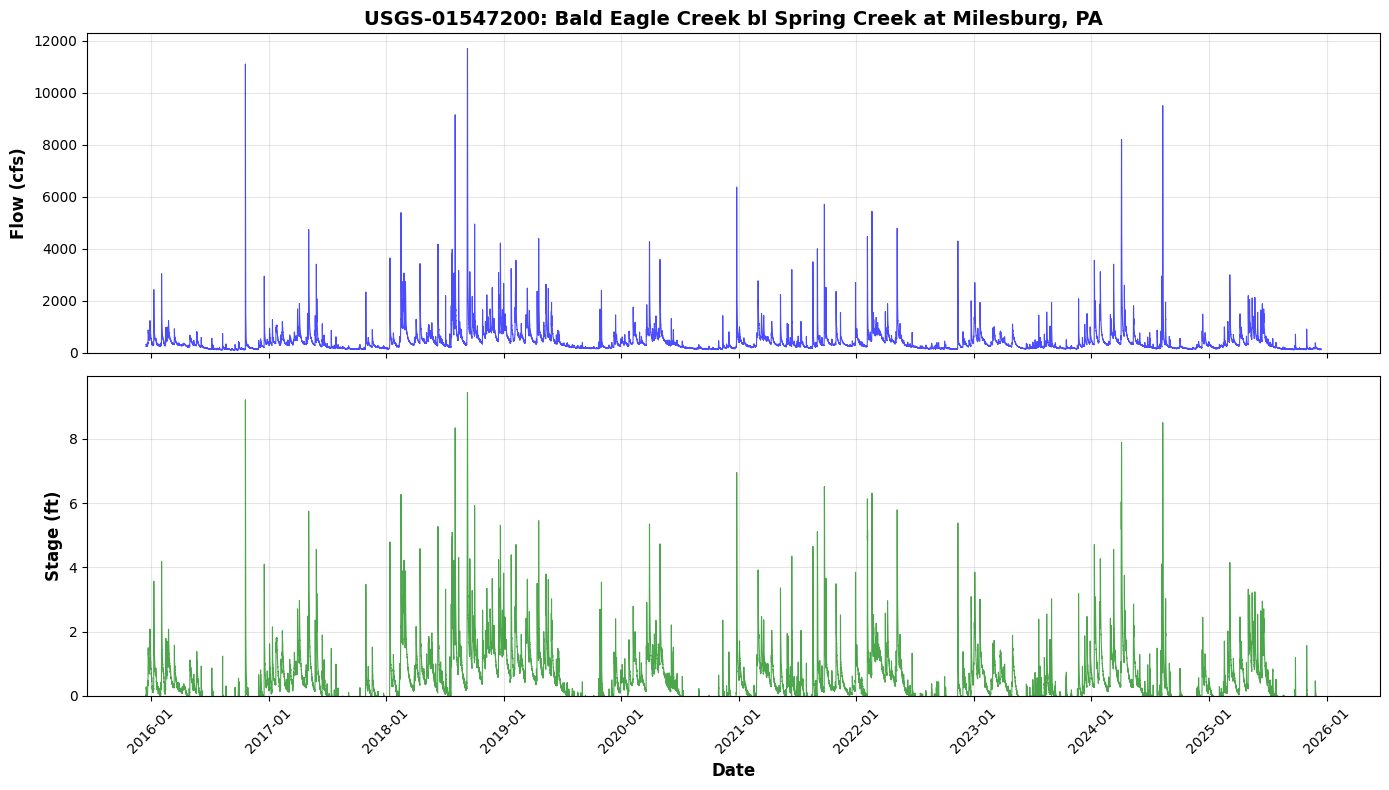


Plot shows 10 years of flow and stage data for USGS-01547200


In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot flow
ax1.plot(flow_data['datetime'], flow_data['value'], 'b-', linewidth=0.8, alpha=0.7)
ax1.set_ylabel('Flow (cfs)', fontsize=12, fontweight='bold')
ax1.set_title(f"USGS-{site_id}: {metadata['station_name']}", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot stage
ax2.plot(stage_data['datetime'], stage_data['value'], 'g-', linewidth=0.8, alpha=0.7)
ax2.set_ylabel('Stage (ft)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nPlot shows 10 years of flow and stage data for USGS-{site_id}")

## 10. Process All Gauges in Catalog

In [12]:
# Summary statistics for all gauges
print("Summary for all gauges:")
print("="*80)

for idx, gauge in catalog.iterrows():
    site_id = gauge['site_id']
    name = gauge['station_name']
    drainage = gauge['drainage_area_sqmi']
    position = gauge['upstream_downstream']
    distance = gauge['distance_to_project_km']
    
    print(f"\nUSGS-{site_id}: {name}")
    print(f"  Position: {position.title()} ({distance:.1f} km from project)")
    print(f"  Drainage: {drainage} sq mi")
    
    # Check if flow data file exists before loading
    gauge_folder = get_gauge_folder(site_id)
    flow_file = gauge_folder / "historical_flow.csv"
    
    if flow_file.exists():
        flow = load_gauge_data(site_id, parameter='flow')
        print(f"  Flow: {len(flow):,} records, mean={flow['value'].mean():.0f} cfs, max={flow['value'].max():.0f} cfs")
    else:
        print(f"  Flow: No data available")
    
    # Check if stage data file exists before loading
    stage_file = gauge_folder / "historical_stage.csv"
    
    if stage_file.exists():
        stage = load_gauge_data(site_id, parameter='stage')
        print(f"  Stage: {len(stage):,} records, mean={stage['value'].mean():.2f} ft, max={stage['value'].max():.2f} ft")
    else:
        print(f"  Stage: No data available")

print("\n" + "="*80)

Summary for all gauges:

USGS-01545680: Tangascootack Creek near Lock Haven, PA
  Position: Unknown (0.0 km from project)
  Drainage: 36.5 sq mi
  Flow: No data available
  Stage: No data available

USGS-01545700: Queens Run near Lock Haven, PA
  Position: Unknown (0.0 km from project)
  Drainage: 18.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01545800: WB Susquehanna River at Lock Haven, PA
  Position: Unknown (0.0 km from project)
  Drainage: 3345.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01546000: North Bald Eagle Creek at Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 119.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01546100: Bald Eagle Creek ab Spring Creek at Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: nan sq mi
  Flow: No data available
  Stage: No data available

USGS-01547000: Spring Creek near Bellefonte, PA
  Position: Unknown (0.0 km from project)
  Drainage: 1

2025-12-14 21:18:39 - ras_commander.usgs.catalog - INFO - Loaded 350795 flow records for gauge 01547100


  Flow: 350,795 records, mean=103 cfs, max=3600 cfs


2025-12-14 21:18:40 - ras_commander.usgs.catalog - INFO - Loaded 350949 stage records for gauge 01547100


  Stage: 350,949 records, mean=-149.45 ft, max=9.33 ft

USGS-01547200: Bald Eagle Creek bl Spring Creek at Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 265.0 sq mi


2025-12-14 21:18:41 - ras_commander.usgs.catalog - INFO - Loaded 348671 flow records for gauge 01547200


  Flow: 348,671 records, mean=453 cfs, max=11700 cfs


2025-12-14 21:18:42 - ras_commander.usgs.catalog - INFO - Loaded 350988 stage records for gauge 01547200


  Stage: 350,988 records, mean=0.45 ft, max=9.44 ft

USGS-01547280: Antis Run near Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 1.56 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547300: Nittany Creek at Curtin, PA
  Position: Unknown (0.0 km from project)
  Drainage: 16.9 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547400: Bald Eagle Creek near Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 296.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547450: Bald Eagle Creek at Howard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 321.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547500: Bald Eagle Creek at Blanchard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 339.0 sq mi


2025-12-14 21:18:43 - ras_commander.usgs.catalog - INFO - Loaded 350290 flow records for gauge 01547500


  Flow: 350,290 records, mean=516 cfs, max=3180 cfs


2025-12-14 21:18:44 - ras_commander.usgs.catalog - INFO - Loaded 350288 stage records for gauge 01547500


  Stage: 350,288 records, mean=3.90 ft, max=7.27 ft

USGS-01547600: Romola Branch near Howard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 5.05 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547700: Marsh Creek at Blanchard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 44.1 sq mi


2025-12-14 21:18:45 - ras_commander.usgs.catalog - INFO - Loaded 345373 flow records for gauge 01547700


  Flow: 345,373 records, mean=-227 cfs, max=4230 cfs


2025-12-14 21:18:46 - ras_commander.usgs.catalog - INFO - Loaded 351557 stage records for gauge 01547700


  Stage: 351,557 records, mean=1.61 ft, max=8.36 ft

USGS-01547900: Big Run at Orviston, PA
  Position: Unknown (0.0 km from project)
  Drainage: 34.2 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547950: Beech Creek at Monument, PA
  Position: Unknown (0.0 km from project)
  Drainage: 152.0 sq mi


2025-12-14 21:18:47 - ras_commander.usgs.catalog - INFO - Loaded 350777 flow records for gauge 01547950


  Flow: 350,777 records, mean=298 cfs, max=6510 cfs


2025-12-14 21:18:48 - ras_commander.usgs.catalog - INFO - Loaded 358165 stage records for gauge 01547950


  Stage: 358,165 records, mean=6.11 ft, max=12.71 ft

USGS-01547980: Beech Creek at Beech Creek, PA
  Position: Unknown (0.0 km from project)
  Drainage: 170.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547990: Beech Creek near Beech Creek, PA
  Position: Unknown (0.0 km from project)
  Drainage: 172.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01548000: Bald Eagle Creek at Beech Creek Station, PA
  Position: Unknown (0.0 km from project)
  Drainage: 559.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01548005: Bald Eagle Creek near Beech Creek Station, PA
  Position: Unknown (0.0 km from project)
  Drainage: 562.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01548010: Bald Eagle Creek near Mill Hall, PA
  Position: Unknown (0.0 km from project)
  Drainage: nan sq mi
  Flow: No data available
  Stage: No data available

USGS-01548018: Fishing CReek at Loganton, PA
  Position: Unknown (0.0 km from proje

## 11. Use Catalog Data for Boundary Conditions

The catalog data can be easily used with other USGS functions:

In [13]:
from ras_commander.usgs import generate_flow_hydrograph_table

# Use the gauge we've been exploring (01547200) which has flow data
# In a real workflow, you'd select the gauge based on drainage area match
# or proximity to your upstream boundary
bc_site_id = '01547200'  # Bald Eagle Creek bl Spring Creek at Milesburg, PA

bc_gauge = catalog[catalog['site_id'] == bc_site_id].iloc[0]

print(f"Using USGS-{bc_site_id} for boundary condition:")
print(f"  Station: {bc_gauge['station_name']}")
print(f"  Drainage: {bc_gauge['drainage_area_sqmi']} sq mi\n")

# Load flow data
flow = load_gauge_data(bc_site_id, parameter='flow')

# Get last 7 days (168 hours)
recent_flow = flow.tail(168).copy()

print(f"Using last {len(recent_flow)} hourly values for BC")
print(f"Date range: {recent_flow['datetime'].min()} to {recent_flow['datetime'].max()}")
print(f"Flow range: {recent_flow['value'].min():.0f} to {recent_flow['value'].max():.0f} cfs\n")

# Generate HEC-RAS format hydrograph table
bc_table = generate_flow_hydrograph_table(
    flow_values=recent_flow['value'],
    interval='1HOUR'
)

print("Generated boundary condition table:")
print(bc_table[:500])  # Show first 500 characters
print(f"\n... ({len(bc_table)} characters total)")

Using USGS-01547200 for boundary condition:
  Station: Bald Eagle Creek bl Spring Creek at Milesburg, PA
  Drainage: 265.0 sq mi



2025-12-14 21:18:49 - ras_commander.usgs.catalog - INFO - Loaded 348671 flow records for gauge 01547200
2025-12-14 21:18:49 - ras_commander.usgs.boundary_generation - INFO - Generated Flow Hydrograph table: 168 values, interval=1HOUR


Using last 168 hourly values for BC
Date range: 2025-12-13 08:45:00+00:00 to 2025-12-15 02:00:00+00:00
Flow range: 128 to 151 cfs

Generated boundary condition table:
Interval=1HOUR
Flow Hydrograph= 168
  137.00  135.00  135.00  137.00  139.00  137.00  137.00  137.00  137.00  139.00
  137.00  135.00  133.00  135.00  135.00  135.00  133.00  133.00  135.00  135.00
  137.00  137.00  135.00  135.00  135.00  135.00  135.00  135.00  137.00  139.00
  139.00  139.00  137.00  137.00  137.00  137.00  137.00  137.00  137.00  137.00
  137.00  139.00  142.00  142.00  139.00  137.00  135.00  135.00  135.00  135.00
  135.00  135.00  135.00  137.00  137.00  135.00  137.00  1

... (1396 characters total)


## 12. Update Catalog (Add New Data)

The `update_gauge_catalog()` function refreshes existing gauges with new data:

In [14]:
# Update catalog with latest data (last 30 days)
update_summary = update_gauge_catalog()

print("\nCatalog Update Summary:")
print("="*60)
print(f"Gauges updated: {update_summary['gauges_updated']}")
print(f"Gauges failed: {update_summary['gauges_failed']}")
print(f"Processing time: {update_summary['processing_time_sec']:.1f} seconds")
print("="*60)

2025-12-14 21:18:49 - ras_commander.usgs.catalog - INFO - Loaded gauge catalog: 47 gauges from C:\GH\ras-commander\examples\example_projects_420_usgs_gauge_catalog\Balde Eagle Creek\USGS Gauge Data\gauge_catalog.csv
2025-12-14 21:18:49 - ras_commander.usgs.catalog - INFO - Updating gauge catalog: 47 gauges
2025-12-14 21:18:49 - ras_commander.usgs.catalog - INFO - Rate limiting enabled: 5.0 requests/sec
2025-12-14 21:18:49 - ras_commander.usgs.catalog - WARNING - No USGS API key configured. Register at: https://api.waterdata.usgs.gov/signup/
Updating gauges: 100%|██████████| 47/47 [00:00<00:00, 1889.69it/s]
2025-12-14 21:18:49 - ras_commander.usgs.catalog - INFO - Catalog update complete: 47 updated, 0 failed



Catalog Update Summary:
Gauges updated: 47
Gauges failed: 0
Processing time: 0.0 seconds


## 13. Custom Catalog Configuration

You can customize the catalog generation:

In [15]:
# Example: Generate catalog with custom settings
# (Don't run this cell if you want to keep existing catalog)

if False:  # Set to True to run
    custom_summary = generate_gauge_catalog(
        buffer_percent=100.0,        # Wider search area (2x project extent)
        include_historical=True,
        historical_years=20,         # More historical data
        parameters=['flow', 'stage', 'temperature'],  # Additional parameters
        output_folder=None           # Use default location
    )
    
    print("Custom catalog generated:")
    print(f"  Gauges: {custom_summary['gauge_count']}")
    print(f"  Data size: {custom_summary['data_size_mb']:.2f} MB")

## Summary

This notebook demonstrated:

1. ✅ **Catalog Generation**: One-command gauge discovery and data download
2. ✅ **Standard Structure**: Consistent folder organization across projects
3. ✅ **Metadata Management**: Complete gauge information in JSON format
4. ✅ **Data Loading**: Easy access to historical gauge data
5. ✅ **Integration**: Seamless use with boundary condition generation
6. ✅ **Updates**: Refresh catalog with latest data

## Key Takeaways

- **Standard Location**: `project_folder/USGS Gauge Data/` (like precipitation module)
- **One Command**: `generate_gauge_catalog()` does everything
- **Engineering Review**: Master catalog CSV for easy gauge assessment
- **Downstream Functions**: Standard location for automated workflows
- **Documentation**: Auto-generated README with usage instructions

## Related Examples

- Example 29: USGS Gauge Data Integration (basic retrieval)
- Example 30: Real-Time Monitoring (live gauge data)
- Example 31: BC Generation from Live Gauge (boundary conditions)
- Example 32: Model Validation with USGS (calibration metrics)

## Next Steps

With the catalog generated, you can:
- Review all available gauges in one location
- Use gauge data for boundary condition generation
- Perform model validation with observed data
- Include catalog in project deliverables for documentation